In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


In [7]:
training_set_labels=pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\training_set_labels.csv')
training_set_values=pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\traning_set_values.csv') 

Train_data = pd.merge(training_set_values, training_set_labels, on='id')
df=Train_data.copy()

test_set_values = pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\test_set_values.csv')


In [5]:
Train_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [6]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [18]:
category = Train_data.select_dtypes(include='object').columns.tolist()
len(category)

31

In [14]:
categorical_columns = [
    'wpt_name',
    'subvillage',
    'scheme_name',
    'installer',
    'ward',
    'funder',
    'date_recorded',
    'lga',
    'region',
    'extraction_type',
    'extraction_type_group',
    'scheme_management',
    'management',
    'source',
    'basin',
    'water_quality',
    'payment',
    'waterpoint_type',
    'source_type',
    'payment_type',
    'extraction_type_class',
    'quality_group',
    'waterpoint_type_group',
    'management_group',
    'quantity',
    'quantity_group',
    'source_class',
    'public_meeting',
    'permit',
    'recorded_by'
]


In [20]:
len(categorical_columns)

30

In [23]:
list(set(category) - set(categorical_columns))


['status_group']

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# -----------------------------
# Data Cleaning and Encoding
# -----------------------------
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

categorical_cols = []
encoders = {}

def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# Model Evaluation Function
# -----------------------------
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔍 {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# -----------------------------
# Compare Ensemble Models
# -----------------------------
def compare_ensemble_models(train_df, data_proportion=1.0, random_state=42):
    train_df = clean_encode(train_df, is_train=True)

    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    # Encode target labels to integers
    y_encoded, y_labels = pd.factorize(y)

    if data_proportion < 1.0:
        X, _, y_encoded, _ = train_test_split(X, y_encoded, train_size=data_proportion, stratify=y_encoded, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=random_state)

    models = {
        'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=None, random_state=random_state),
        'XGBoost': XGBClassifier(n_estimators=500, max_depth=8, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state),
        'LightGBM': LGBMClassifier(n_estimators=500, max_depth=8, random_state=random_state)
    }

    for name, model in models.items():
        evaluate_model(model, X_train, X_test, y_train, y_test, name)

    return models


In [ ]:
compare_ensemble_models(df, data_proportion=1, random_state=42)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13144\3525489613.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)



🔍 Random Forest
Accuracy: 0.8125
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      6452
           1       0.85      0.78      0.81      4565
           2       0.57      0.33      0.42       863

    accuracy                           0.81     11880
   macro avg       0.74      0.67      0.69     11880
weighted avg       0.81      0.81      0.81     11880



C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [22:57:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔍 XGBoost
Accuracy: 0.8003
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      6452
           1       0.83      0.78      0.80      4565
           2       0.51      0.31      0.39       863

    accuracy                           0.80     11880
   macro avg       0.72      0.66      0.68     11880
weighted avg       0.79      0.80      0.79     11880

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 33
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Info] Start training from score -2.621618

🔍 LightGBM
Accuracy: 0.8024
Classification Report:
 

{'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=8, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=500, n_jobs=None,
               num_parallel_tree=None, ...),
 'LightGBM': LGBMClassifier(max_depth=8, n_estimators=500, random_state=42)}

In [3]:

# Columns to drop
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# Define a function to map each month to its ordinal value
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

# Global categorical columns and encoders
categorical_cols = []
encoders = {}

# -----------------------------
# 1. Preprocessing + Encoding
# -----------------------------
def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# 2. Model Building
# -----------------------------
def build_model(train_df, data_proportion=1.0, n_estimators=550, max_depth=None, random_state=42):
    train_df = clean_encode(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight = 'balanced',random_state=random_state)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Model trained on {data_proportion*100:.1f}% of data")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'model': model
    }

# -----------------------------
# 3. Predict on Test Set
# -----------------------------
def predict_test_set(model_data, test_df):
    test_df_cleaned = clean_encode(test_df, is_train=False)
    model = model_data['model']

    predictions = model.predict(test_df_cleaned)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"\u2705 Saved {len(result_df)} predictions to {filename}")

    return result_df


C:\Users\Admin\AppData\Local\Temp\ipykernel_25560\1243544469.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)


Model trained on 100.0% of data
Accuracy: 0.8125
Classification Report:
                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6452
functional needs repair       0.57      0.32      0.41       863
         non functional       0.85      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.74      0.67      0.69     11880
           weighted avg       0.81      0.81      0.80     11880



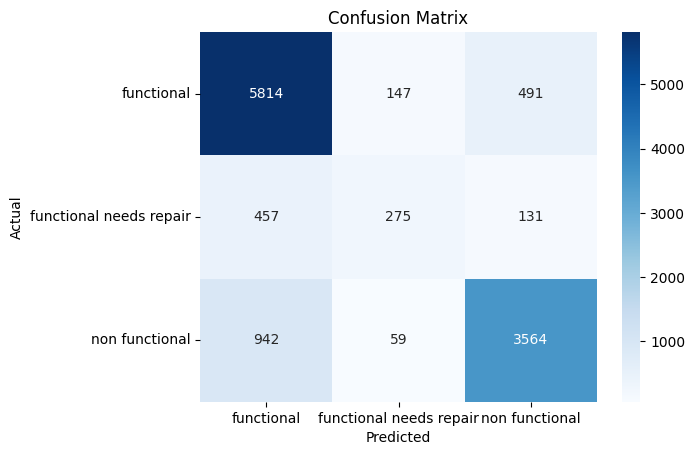

In [4]:
rf_model=build_model(df, data_proportion=1, n_estimators=300, max_depth=None, random_state=42)

In [6]:
model_data=rf_model
predict_test_set(model_data, test_set_values)

C:\Users\Admin\AppData\Local\Temp\ipykernel_23560\3580636383.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)


✅ Saved 14850 predictions to predictions_2025-04-09_17-27-11.csv


,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


---

# Trying wrapper method

In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE

# 2. Model Building with Feature Selection (Wrapper Method)
# -----------------------------
def build_model_with_wrapper(df, num_features=15, data_proportion=1.0, n_estimators=350, max_depth=None, random_state=42):
    df = clean_encode(df, is_train=True)
    y = df['status_group']
    X = df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    base_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    selector = RFE(estimator=base_model, n_features_to_select=num_features, step=1)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    selected_features = X_train.columns[selector.support_]
    print("Selected features:", list(selected_features))

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Model trained on {data_proportion*100:.1f}% of data")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'model': model,
        'selector': selector,
        'selected_features': selected_features
    }

# -----------------------------
# 3. Predict on Test Set
# -----------------------------
def predict_test_set_wrapper(model_data, test_df):
    test_df_cleaned = clean_encode(test_df, is_train=False)
    model = model_data['model']
    selector = model_data['selector']

    X_test = test_df_cleaned[model_data['selected_features']]
    X_test_selected = selector.transform(X_test)

    predictions = model.predict(X_test_selected)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df


C:\Users\Admin\AppData\Local\Temp\ipykernel_23560\440030689.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)


Selected features: ['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'subvillage', 'region', 'lga', 'ward', 'population', 'scheme_name', 'construction_year', 'extraction_type_group', 'extraction_type_class', 'payment', 'quantity', 'quantity_group', 'waterpoint_type_group']
Model trained on 80.0% of data
Accuracy: 0.8043
Precision: 0.7982
Recall: 0.8043
F1 Score: 0.7965

Classification Report:
                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      5161
functional needs repair       0.57      0.32      0.41       691
         non functional       0.84      0.77      0.80      3652

               accuracy                           0.80      9504
              macro avg       0.74      0.66      0.69      9504
           weighted avg       0.80      0.80      0.80      9504



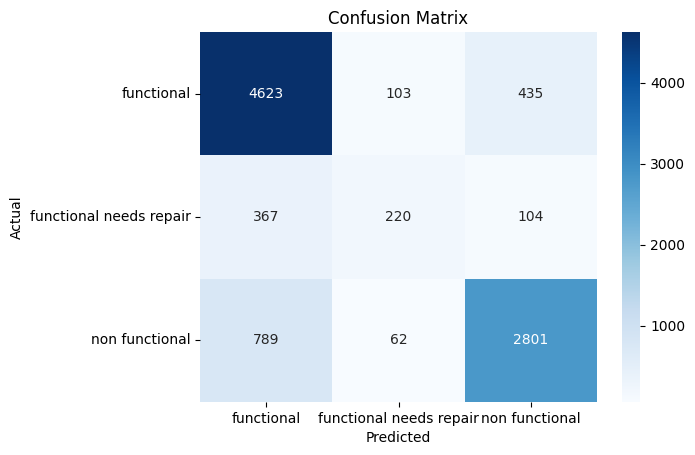

{'model': RandomForestClassifier(n_estimators=550, random_state=42),
 'selector': RFE(estimator=RandomForestClassifier(n_estimators=550, random_state=42),
     n_features_to_select=20),
 'selected_features': Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
        'latitude', 'subvillage', 'region', 'lga', 'ward', 'population',
        'scheme_name', 'construction_year', 'extraction_type_group',
        'extraction_type_class', 'payment', 'quantity', 'quantity_group',
        'waterpoint_type_group'],
       dtype='object')}

In [ ]:
build_model_with_wrapper(df, num_features=20,data_proportion=0.2)


---

# Frequency Encoding

In [28]:
# Columns to drop
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# Define a function to map each month to its ordinal value
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

# Global categorical columns and encoders
categorical_cols = []
#frequency_maps
frequency_maps = {}  # Add frequency maps dictionary

# -----------------------------
# 1. Preprocessing + Encoding
# -----------------------------
def clean_encode_frequency(df, is_train=True):
    global categorical_cols, encoders, frequency_maps

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}
        frequency_maps = {}

        # Frequency encoding for categorical columns
        for col in categorical_cols:
            # Calculate frequency of each category
            freq = df[col].value_counts(normalize=True).to_dict()
            frequency_maps[col] = freq
            # Create frequency encoded feature
            df[f'{col}_freq'] = df[col].map(freq)
            
            # Still apply label encoding as before
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                # Apply frequency encoding
                if col in frequency_maps:
                    df[f'{col}_freq'] = df[col].map(frequency_maps[col])
                    df[f'{col}_freq'].fillna(0, inplace=True)  # Handle unseen categories
                
                # Apply label encoding
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# 2. Model Building
# -----------------------------
def build_model_frequency(train_df, data_proportion=1.0, n_estimators=550, max_depth=None, random_state=42):
    train_df = clean_encode_frequency(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Model trained on {data_proportion*100:.1f}% of data")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'model': model
    }

# -----------------------------
# 3. Predict on Test Set
# -----------------------------
def predict_test_set_frequency(model_data, test_df):
    test_df_cleaned = clean_encode_frequency(test_df, is_train=False)  # Fixed function name
    model = model_data['model']

    predictions = model.predict(test_df_cleaned)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"\u2705 Saved {len(result_df)} predictions to {filename}")

    return result_df


C:\Users\Admin\AppData\Local\Temp\ipykernel_12024\292606128.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)


Model trained on 100.0% of data
Accuracy: 0.8113
Classification Report:
                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6452
functional needs repair       0.54      0.33      0.41       863
         non functional       0.85      0.78      0.82      4565

               accuracy                           0.81     11880
              macro avg       0.73      0.67      0.69     11880
           weighted avg       0.80      0.81      0.80     11880



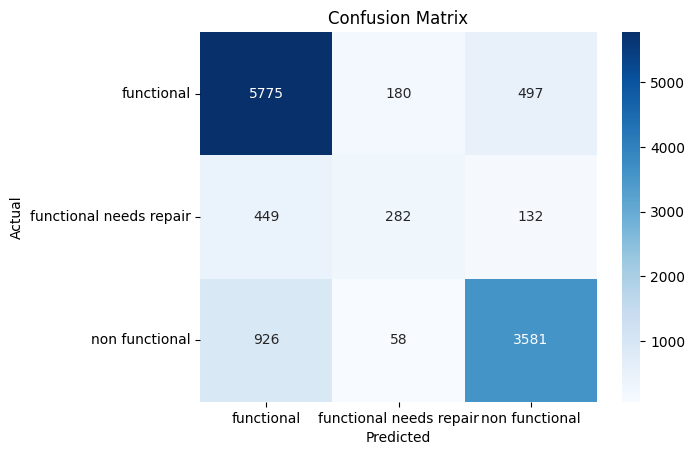

In [14]:
rf_model=build_model_frequency(df, data_proportion=1, n_estimators=900, max_depth=None, random_state=42)

---

# Custom encoding

C:\Users\Admin\AppData\Local\Temp\ipykernel_25268\2332368427.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25268\2332368427.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

Model trained on 100.0% of data
Accuracy: 0.8106
Classification Report:
                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6452
functional needs repair       0.55      0.32      0.41       863
         non functional       0.85      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.73      0.67      0.69     11880
           weighted avg       0.80      0.81      0.80     11880



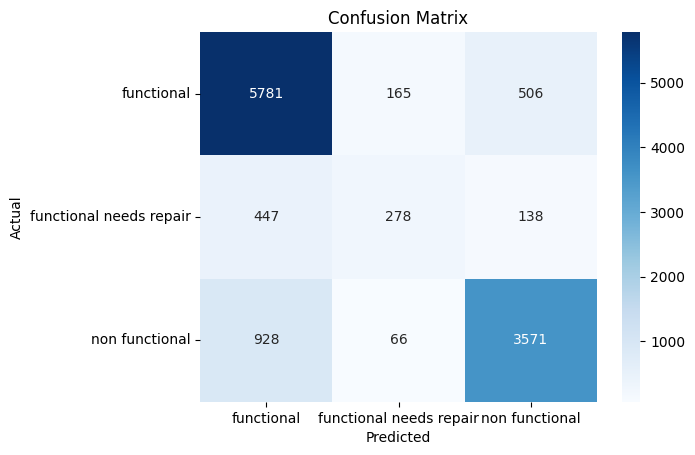

In [29]:

# Columns to drop
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

# Global categorical columns and encoders
categorical_cols = []
encoders = {}

# -----------------------------
# 1. Preprocessing + Encoding
# -----------------------------
# -----------------------------
# 1. Preprocessing + Encoding
# -----------------------------
def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    # Group rare categories for specific columns
    def group_rare_categories(column, top_n=50):
        top_categories = column.value_counts(normalize=True).nlargest(top_n).index
        return column.apply(lambda x: x if x in top_categories else "Other")

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)

        # Apply rare category grouping for specific columns
        if col in ['funder', 'installer', 'scheme_management', 'scheme_name', 'subvillage']:
            df[col] = group_rare_categories(df[col])

    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = "Other"
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# 2. Model Building
# -----------------------------
def build_model_custom(train_df, data_proportion=1.0, n_estimators=550, max_depth=None, random_state=42):
    train_df = clean_encode(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Model trained on {data_proportion*100:.1f}% of data")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'model': model
    }

# -----------------------------
# 3. Predict on Test Set
# -----------------------------
def predict_test_set(model_data, test_df):
    test_df_cleaned = clean_encode(test_df, is_train=False)
    model = model_data['model']

    predictions = model.predict(test_df_cleaned)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"\u2705 Saved {len(result_df)} predictions to {filename}")

    return result_df

rf_model=build_model_custom(df, data_proportion=1, n_estimators=250, max_depth=None, random_state=42)



# Interpertating the Random forest

                  Feature  Importance
5               longitude    0.087781
6                latitude    0.084975
28         quantity_group    0.071319
0                      id    0.064667
27               quantity    0.064441
9              subvillage    0.059633
3              gps_height    0.047024
31  waterpoint_type_group    0.044695
14                   ward    0.040396
20      construction_year    0.039992


C:\Users\Admin\AppData\Local\Temp\ipykernel_11084\3322796875.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances_df.head(15), x='Importance', y='Feature', palette='viridis')


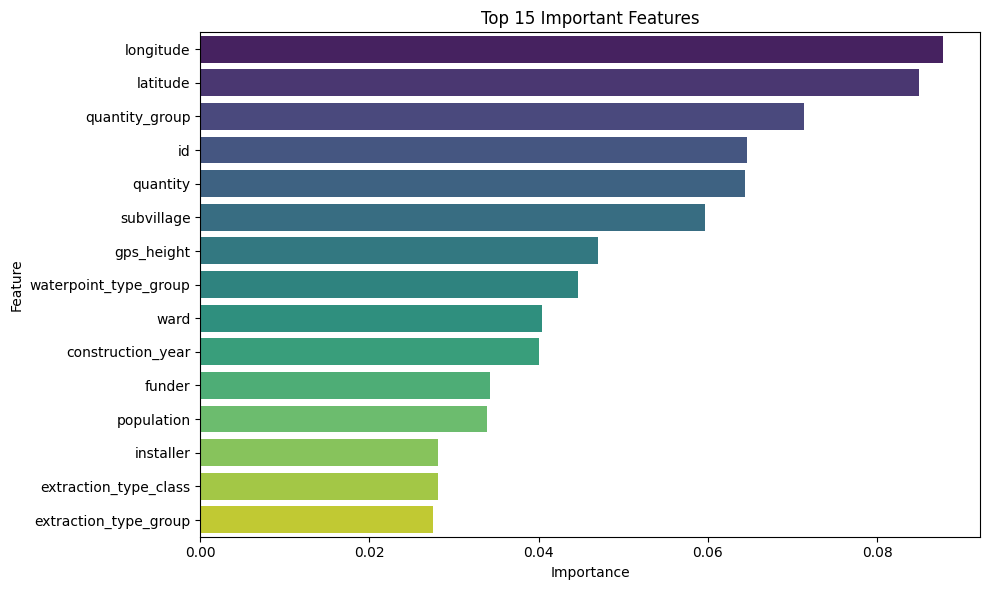

In [12]:
importances = rf_model['model'].feature_importances_
feature_names = rf_model['model'].feature_names_in_

# Combine into a DataFrame for easier viewing
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top features
print(importances_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Important Features")
plt.tight_layout()
plt.show()

# Trying Dimensionality Reduciton

In [30]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# -----------------------------
# Columns to Drop
# -----------------------------
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# -----------------------------
# Raininess Mapping
# -----------------------------
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

# Global variables
categorical_cols = []
encoders = {}

# -----------------------------
# Preprocessing + Encoding
# -----------------------------
def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# Model Building with Optional PCA
# -----------------------------
def build_model(train_df, data_proportion=1.0, n_estimators=550, max_depth=None,
                random_state=42, use_pca=False, n_components=None):

    train_df = clean_encode(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    scaler = None
    pca = None
    if use_pca:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        pca = PCA(n_components=n_components)
        X = pca.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Model trained on {data_proportion*100:.1f}% of data")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'model': model,
        'scaler': scaler,
        'pca': pca
    }

# -----------------------------
# Predict on Test Set with Optional PCA
# -----------------------------
def predict_test_set(model_data, test_df):
    test_df_cleaned = clean_encode(test_df, is_train=False)

    if model_data.get('scaler') and model_data.get('pca'):
        test_df_cleaned = model_data['scaler'].transform(test_df_cleaned)
        test_df_cleaned = model_data['pca'].transform(test_df_cleaned)

    model = model_data['model']
    predictions = model.predict(test_df_cleaned)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"\u2705 Saved {len(result_df)} predictions to {filename}")

    return result_df






C:\Users\Admin\AppData\Local\Temp\ipykernel_25268\582801270.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)


Model trained on 100.0% of data
Accuracy: 0.7830
Classification Report:
                         precision    recall  f1-score   support

             functional       0.79      0.87      0.83      6452
functional needs repair       0.49      0.26      0.34       863
         non functional       0.81      0.75      0.78      4565

               accuracy                           0.78     11880
              macro avg       0.69      0.63      0.65     11880
           weighted avg       0.77      0.78      0.77     11880



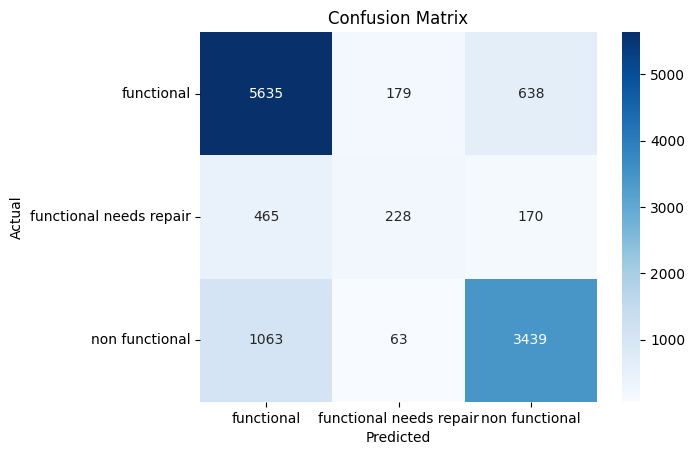

In [31]:
# Train the model using PCA with 20 components
rf_model = build_model(df, data_proportion=1, use_pca=True, n_components=33, n_estimators=250)

# Predict on test data using same transformation
#preds = predict_test_set(rf_model, test_set_values)


# Plot for PCA

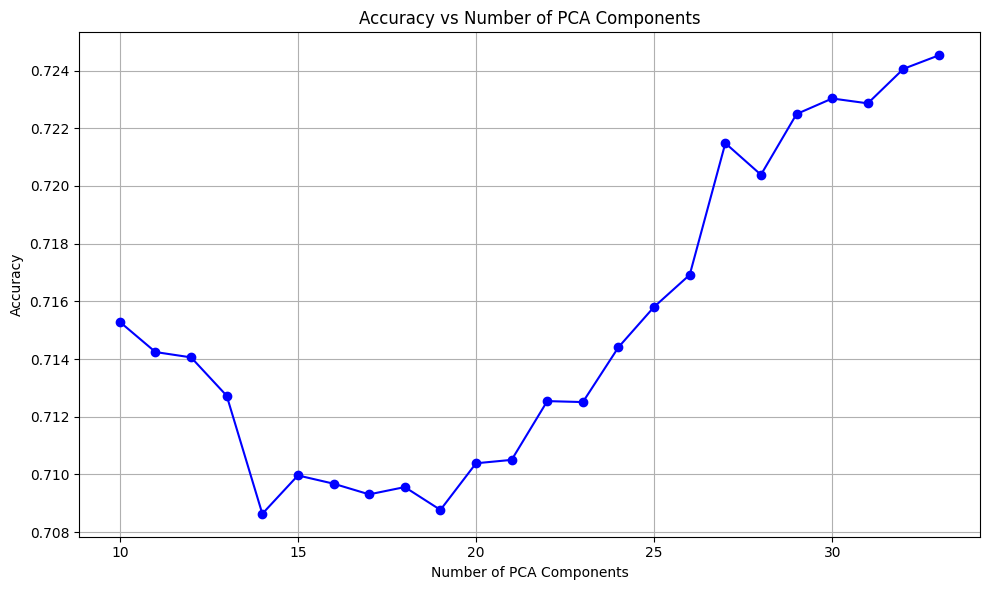

In [ ]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


# -----------------------------
# Columns to Drop
# -----------------------------
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# -----------------------------
# Raininess Mapping
# -----------------------------
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4
    elif month in [10, 11, 12]:
        return 3
    elif month in [1, 2]:
        return 2
    else:
        return 1

# Global variables
categorical_cols = []
encoders = {}

# -----------------------------
# Preprocessing + Encoding
# -----------------------------
def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# Model Building with PCA (No Output)
# -----------------------------
def build_model_silent(train_df, data_proportion=1.0, n_estimators=250,
                       random_state=42, use_pca=False, n_components=None):

    train_df = clean_encode(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    scaler = None
    pca = None
    if use_pca:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        pca = PCA(n_components=n_components)
        X = pca.fit_transform(X)

    model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    model.fit(X, y)

    return {
        'model': model,
        'scaler': scaler,
        'pca': pca
    }

# -----------------------------
# PCA Accuracy Benchmark Loop
# -----------------------------
accuracies = []
components_range = range(10, 34)

for n_components in components_range:
    rf_model = build_model_silent(df, data_proportion=0.05, use_pca=True,
                                   n_components=n_components, n_estimators=250)
    
    df_cleaned = clean_encode(df.copy(), is_train=False)
    X_eval = df_cleaned.drop(columns=['status_group'])
    y_eval = df_cleaned['status_group']

    X_eval = rf_model['scaler'].transform(X_eval)
    X_eval = rf_model['pca'].transform(X_eval)

    y_pred = rf_model['model'].predict(X_eval)
    accuracy = accuracy_score(y_eval, y_pred)
    accuracies.append(accuracy)

# -----------------------------
# Final Accuracy Plot
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(components_range, accuracies, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs Number of PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Accuracy")
plt.grid()
plt.tight_layout()
plt.show()


In [5]:
print(accuracies)

[0.7152861952861953, 0.7142424242424242, 0.7140572390572391, 0.7127272727272728, 0.7086363636363636, 0.7099663299663299, 0.7096801346801347, 0.7093097643097643, 0.7095622895622896, 0.7087710437710437, 0.7103872053872053, 0.7105050505050505, 0.7125420875420876, 0.7125084175084175, 0.7144107744107744, 0.7158080808080808, 0.716919191919192, 0.7214814814814815, 0.7203872053872054, 0.7224915824915825, 0.723030303030303, 0.7228619528619529, 0.7240572390572391, 0.7245286195286196]


# Neural Network trial

In [ ]:
# I generated a basic code but i need to downgrade python to run tensor flow which I currently dont want

In [33]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder


# -----------------------------
# Columns to drop
# -----------------------------
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# Define a function to map each month to its ordinal value
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

# Global categorical columns and encoders
categorical_cols = []
encoders = {}

# -----------------------------
# 1. Preprocessing + Encoding
# -----------------------------
def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# 2. Neural Network Model Building
# -----------------------------
def build_nn_model(train_df, data_proportion=1.0, random_state=42):
    train_df = clean_encode(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    # Neural Network architecture
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input layer + hidden layer 1
    model.add(Dense(64, activation='relu'))  # Hidden layer 2
    model.add(Dense(32, activation='relu'))  # Hidden layer 3
    model.add(Dense(3, activation='softmax'))  # Output layer (3 classes)

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=Adam(), 
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"Model trained on {data_proportion*100:.1f}% of data")
    print(f"Accuracy: {accuracy:.4f}")

    # Predict on test data
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'model': model
    }

# -----------------------------
# 3. Predict on Test Set
# -----------------------------
def predict_test_set(model_data, test_df):
    test_df_cleaned = clean_encode(test_df, is_train=False)
    model = model_data['model']

    predictions = np.argmax(model.predict(test_df_cleaned), axis=1)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"\u2705 Saved {len(result_df)} predictions to {filename}")

    return result_df


In [34]:
# Build and train the neural network model
model_data = build_nn_model(df, data_proportion=1.0, random_state=42)


C:\Users\Admin\AppData\Local\Temp\ipykernel_25268\3816639119.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)


NameError: name 'Sequential' is not defined

In [ ]:
# Use the trained model to predict on the test set
result_df = predict_test_set(model_data, test_set_values)

# Print the results
print(result_df.head())


# Ensemble Method , soft voting

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# -----------------------------
# Data Cleaning and Encoding
# -----------------------------
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

categorical_cols = []
encoders = {}

def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# Model Evaluation Function
# -----------------------------
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔍 {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# -----------------------------
# Ensemble Model - Soft Voting Classifier
# ----------------------------- 
def ensemble_model_with_proba(train_df, data_proportion=1.0, random_state=42):
    # Data Preprocessing and Encoding
    train_df = clean_encode(train_df, is_train=True)

    # Splitting features (X) and target (y)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    # Encode target labels to integers
    y_encoded, y_labels = pd.factorize(y)

    # Split the data into training and testing sets
    if data_proportion < 1.0:
        X, _, y_encoded, _ = train_test_split(X, y_encoded, train_size=data_proportion, stratify=y_encoded, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=random_state)

    # Define individual models
    rf_model = RandomForestClassifier(n_estimators=500, max_depth=None, random_state=random_state)
    xgb_model = XGBClassifier(n_estimators=500, max_depth=8, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    lgbm_model = LGBMClassifier(n_estimators=500, max_depth=8, random_state=random_state)

    # Create a Soft Voting Classifier (ensemble model)
    ensemble = VotingClassifier(estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ], voting='soft')  # 'soft' voting uses the predicted probabilities

    # Train and evaluate the ensemble model
    evaluate_model(ensemble, X_train, X_test, y_train, y_test, "Ensemble Soft Voting Classifier")

    return ensemble

def compare_ensemble_models(train_df, data_proportion=1.0, random_state=42):
    ensemble_model = ensemble_model_with_proba(train_df, data_proportion, random_state)
    return ensemble_model




In [8]:
ensemble_model = compare_ensemble_models(df, data_proportion=1.0, random_state=42)


C:\Users\Admin\AppData\Local\Temp\ipykernel_25560\613565089.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)
C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [14:14:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 33
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Info] Start training from score -2.621618

🔍 Ensemble Soft Voting Classifier
Accuracy: 0.8074
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      6452
           1       0.85      0.77      0.81      4565
           2       0.56      0.31      0.40       863

    accuracy                           0.81     11880
   macro avg       0.74      0.66      0.69     11880
weighted avg       0.80      0.81      0.80     11880

